In [47]:
import cv2
import pandas as pd
from ultralytics import YOLO
from tracker import*
import matplotlib.pyplot as plt

In [48]:
model=YOLO('yolov8s.pt')

In [49]:
class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [50]:
tracker=Tracker()
count=0

In [51]:
cap=cv2.VideoCapture('highway.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)


In [52]:
down={}
up={}

counter_down=[]
counter_up=[]

up_count_over_time = []
down_count_over_time = []

In [53]:
while True:    
    ret, frame = cap.read()
    if not ret:
        break
    count += 1
    frame = cv2.resize(frame, (1020, 500))

    # Run YOLO model prediction on each frame
    results = model.predict(frame)
    a = results[0].boxes.data
    a = a.detach().cpu().numpy()  
    px = pd.DataFrame(a).astype("float")

    list = []
             
    # Extract bounding boxes 
    for index, row in px.iterrows(): 
        x1 = int(row[0])
        y1 = int(row[1])
        x2 = int(row[2])
        y2 = int(row[3])
        d = int(row[5])
        c = class_list[d]
        if 'car' in c or 'truck' in c or 'bus' in c:
            list.append([x1, y1, x2, y2])
            
    # Update object tracker 
    bbox_id = tracker.update(list)
    for bbox in bbox_id:
        x3, y3, x4, y4, id = bbox
        cx = int(x3 + x4) // 2
        cy = int(y3 + y4) // 2

        red_line_y = 198
        blue_line_y = 268   
        offset = 7

        color = (0, 255, 0)

        # Detect vehicles moving downward (crossing red then blue line)
        if red_line_y < (cy + offset) and red_line_y > (cy - offset):
            down[id] = cy   
        if id in down:
            if blue_line_y < (cy + offset) and blue_line_y > (cy - offset):         
                cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
                cv2.putText(frame, str(id), (cx, cy), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)
                # Count vehicle only once
                if id not in counter_down:
                    counter_down.append(id)  
                color = (255, 0, 0)

        # Detect vehicles moving upward (crossing blue then red line)
        if blue_line_y < (cy + offset) and blue_line_y > (cy - offset):
            up[id] = cy   
        if id in up:
            if red_line_y < (cy + offset) and red_line_y > (cy - offset):         
                cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
                cv2.putText(frame, str(id), (cx, cy), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)
                if id not in counter_up:
                    counter_up.append(id)  
                color = (0, 0, 255)
        
        # Draw bounding box 
        cv2.rectangle(frame, (x3, y3), (x4, y4), color, 2)

    # Draw reference lines (red = upper, blue = lower)
    cv2.line(frame, (172, 198), (774, 198), (0, 0, 255), 3) 
    cv2.line(frame, (8, 268), (927, 268), (255, 0, 0), 3)  

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    thickness = 1

    # Count vehicles in each direction
    downwards = len(counter_down)
    upwards = len(counter_up)

    down_count_over_time.append(downwards)
    up_count_over_time.append(upwards)
    
    # Display text with counts on frame
    text1 = f'going down: {downwards}'
    text2 = f'going up: {upwards}'

    (text_w1, text_h1), _ = cv2.getTextSize(text1, font, font_scale, thickness)
    (text_w2, text_h2), _ = cv2.getTextSize(text2, font, font_scale, thickness)

    x, y1 = 60, 40
    y2 = 60

    # Draw background boxes for count text
    cv2.rectangle(frame, (x - 5, y1 - text_h1 - 5), (x + text_w1 + 5, y1 + 5), (255, 255, 255), -1)
    cv2.rectangle(frame, (x - 5, y2 - text_h2 - 5), (x + text_w1 + 5, y2 + 5), (255, 255, 255), -1)

    # Draw count text on frame
    cv2.putText(frame, text1, (x, y1), font, font_scale, (255, 0, 0), thickness, cv2.LINE_AA)
    cv2.putText(frame, text2, (x, y2), font, font_scale, (0, 0, 255), thickness, cv2.LINE_AA)

    cv2.imshow("frames", frame)
    if cv2.waitKey(1) & 0xFF == 27:
        break
    
# Release video capture and close windows
cap.release()
cv2.destroyAllWindows()



0: 320x640 8 cars, 2 trucks, 94.5ms
Speed: 2.0ms preprocess, 94.5ms inference, 2.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 112.4ms
Speed: 2.1ms preprocess, 112.4ms inference, 2.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 7 cars, 2 trucks, 102.5ms
Speed: 1.9ms preprocess, 102.5ms inference, 3.2ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 6 cars, 2 trucks, 100.9ms
Speed: 1.9ms preprocess, 100.9ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 176.1ms
Speed: 1.9ms preprocess, 176.1ms inference, 3.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 124.5ms
Speed: 3.1ms preprocess, 124.5ms inference, 2.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 99.9ms
Speed: 2.1ms preprocess, 99.9ms inference, 2.2ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 200.3ms
Speed: 1.9ms p

In [54]:
downwards_ground_truth = 34
upwards_ground_truth = 33

acc1 = downwards / downwards_ground_truth
acc2 = upwards / upwards_ground_truth

print(f"acc1={acc1*100}%")
print(f"acc2={acc2*100}%")

acc1=97.05882352941177%
acc2=100.0%


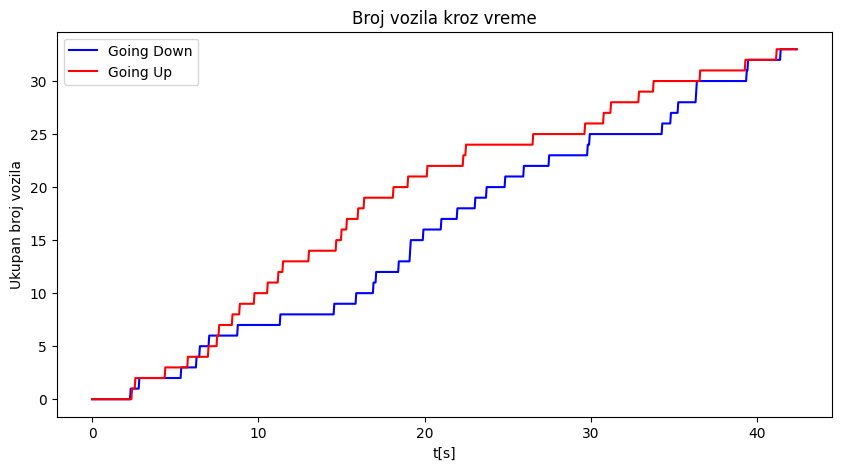

In [55]:
seconds = [i / fps for i in range(len(down_count_over_time))]

plt.figure(figsize=(10,5))
plt.plot(seconds, down_count_over_time, label='Going Down', color='blue')
plt.plot(seconds, up_count_over_time, label='Going Up', color='red')
plt.xlabel('t[s]')
plt.ylabel('Ukupan broj vozila')
plt.title('Broj vozila kroz vreme')
plt.legend()
plt.show()